In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypsa.linopf import *
from pypsa.linopt import *

from pyomo.environ import Constraint

network = pypsa.Network()

def extra_functionality(network, snapshots):
    model = network.model
    model.link_fix = Constraint(
        rule=lambda model: model.link_p_nom["Link2Store"]
        == model.link_p_nom["Link2Main"]* network.links.loc['Link2Main','efficiency'])

# network.snapshots = pd.date_range("2016-01-01 00:00", "2016-01-01 09:00", freq="H")

# print(network.snapshots)

# df = pd.DataFrame({"a":[1,2,3], "b":[2,4,6]})
# df.plot(kind="scatter",x="a",y="b")
# plt.show()

timescale_10h = pd.date_range("2016-01-01 00:00", "2016-01-01 09:00", freq="H")
timescale_30d = pd.date_range("2016-01-01 00:00", "2016-01-30 23:00", freq="H")
timescales = [timescale_10h,timescale_30d]

network.add("Bus", "Main", v_nom=380)
network.add(
    "Load", 
    name="TotalLoads", 
    bus="Main", 
    p_set=23000)

network.add("Bus", "StoreIsland", carrier="AC")
#parameterBank parameters = [Link 1 capital_cost, Link 1 efficiency, Link 2 capital_cost, Link 2 efficiency, Store capital costs]
parameterBank = [[0.2055  , 0.9     , 0.2055  , 0.9     , 0.192   ], #Lithium
       [0.35    , 0.8     , 0.35    , 0.58    , 0.01064 ], #H2
       [0.462238, 0.7211  , 0.633112, 0.7211  , 0.003477], #CAES
       [0.367   , 0.7746  , 0.367   , 0.7746  , 0.09437 ], #LAES
       [0.17766 , 0.6708  , 0.17766 , 0.6708  , 0.08883 ], #ETES
       [0.176515, 0.866   , 0.176515, 0.866   , 0.62289 ], #NaS
       [0.75    , 0.8944  , 0.75    , 0.8944  , 0.125   ]] #Fe-Flow
storeSeriesData_10h = pd.DataFrame()
storeSeriesData_30d = pd.DataFrame()
storeObjectives = [[0 for a in range(7)],[0 for b in range(7)]]
storeCapacities = [[0 for a in range(7)],[0 for b in range(7)]]
# storeCapacities10 = [0 for a in range(7)]
# storeCapacities30 = [0 for b in range(7)]

for h in range(2):
    network.snapshots = timescales[h]
    
    network.add(
    "Generator", 
    name="TotalGenerators", 
    bus="Main", 
    p_nom=32500,
    p_max_pu=(6250*np.cos(np.linspace(0,9,num=network.snapshots.size)*(np.pi/9))+26250)/32500,
    capital_cost=1.04*10**6,
    efficiency=1,
    marginal_cost=2.3,
    carrier="AC")

    for i in range(7):
        #LINKS
        #Charger Link
        network.add(
            "Link",
            name="Link2Store",
            bus0="Main",
            bus1="StoreIsland",
            capital_cost=parameterBank[i][0]*10**6,
            p_nom_extendable=True,
            #marginal_cost=0,
            efficiency=parameterBank[i][1],
        )

        #Discharger Link
        network.add(
            "Link",
            name="Link2Main",
            bus0="StoreIsland",
            bus1="Main",
            capital_cost=parameterBank[i][2]*10**6,
            p_nom_extendable=True,
            #marginal_cost=0.01,
            efficiency=parameterBank[i][3]
        )

        #STORE
        network.add(
            "Store",
            "TheStorage",
            bus="StoreIsland",
            capital_cost=parameterBank[i][4]*10**6,
            e_nom_extendable=True,
            e_cyclic=True
        )

        if i==0 or i==5 or i==6:
            network.lopf(extra_functionality=extra_functionality)
        else:
            network.lopf()
        
        if h==0:
            storeSeriesData_10h = storeSeriesData_10h.append(network.stores_t.e)
            # storeCapacities10[i]=network.stores.e_nom_opt
        elif h==1:
            storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)
            # storeCapacities30[i]=network.stores.e_nom_opt

        storeObjectives[h][i] = network.objective
        storeCapacities[h][i] = network.stores.e_nom_opt

        network.mremove("Store",["TheStorage"])
        network.mremove("Link",["Link2Main","Link2Store"])

    network.mremove("Generator",["TotalGenerators"])


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2829682281.86621
  Upper bound: 2829682281.86621
  Number of objectives: 1
  Number of constraints: 92
  Number of variables: 54
  Number of nonzeros: 183
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7282063961029053
# ----------------------------------------------------------
#   Solution Information
# ------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_10h = storeSeriesData_10h.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2862280261.26851
  Upper bound: 2862280261.26851
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7350313663482666
# ----------------------------------------------------------
#   Solution Information
# ------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_10h = storeSeriesData_10h.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3730458690.77235
  Upper bound: 3730458690.77235
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7524468898773193
# ----------------------------------------------------------
#   Solution Information
# ------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_10h = storeSeriesData_10h.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful
/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) s

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3016687818.88285
  Upper bound: 3016687818.88285
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7469370365142822
# ----------------------------------------------------------
#   Solution Information
# ------------

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful
/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_10h = storeSeriesData_10h.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2227460076.22702
  Upper bound: 2227460076.22702
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7190628051757812
# ----------------------------------------------------------
#   Solution Information
# ------------

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 6292170713.3896
  Upper bound: 6292170713.3896
  Number of objectives: 1
  Number of constraints: 92
  Number of variables: 54
  Number of nonzeros: 183
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7552900314331055
# ----------------------------------------------------------
#   Solution Information
# --------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_10h = storeSeriesData_10h.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 5766976635.2646
  Upper bound: 5766976635.2646
  Number of objectives: 1
  Number of constraints: 92
  Number of variables: 54
  Number of nonzeros: 183
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7517447471618652
# ----------------------------------------------------------
#   Solution Information
# --------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_10h = storeSeriesData_10h.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 99832204767.0167
  Upper bound: 99832204767.0167
  Number of objectives: 1
  Number of constraints: 6482
  Number of variables: 3604
  Number of nonzeros: 12963
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.9554476737976074
# ----------------------------------------------------------
#   Solution Information
# ------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 11111245587.7323
  Upper bound: 11111245587.7323
  Number of objectives: 1
  Number of constraints: 6481
  Number of variables: 3604
  Number of nonzeros: 12961
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 1.1603977680206299
# ----------------------------------------------------------
#   Solution Information
# ------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 5821842166.73752
  Upper bound: 5821842166.73752
  Number of objectives: 1
  Number of constraints: 6481
  Number of variables: 3604
  Number of nonzeros: 12961
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 1.1430094242095947
# ----------------------------------------------------------
#   Solution Information
# ------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 58334304523.8985
  Upper bound: 58334304523.8985
  Number of objectives: 1
  Number of constraints: 6481
  Number of variables: 3604
  Number of nonzeros: 12961
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 1.0784337520599365
# ----------------------------------------------------------
#   Solution Information
# ------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 62387844952.4499
  Upper bound: 62387844952.4499
  Number of objectives: 1
  Number of constraints: 6481
  Number of variables: 3604
  Number of nonzeros: 12961
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 1.211280345916748
# ----------------------------------------------------------
#   Solution Information
# -------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 333255345448.24
  Upper bound: 333255345448.24
  Number of objectives: 1
  Number of constraints: 6482
  Number of variables: 3604
  Number of nonzeros: 12963
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.9737865924835205
# ----------------------------------------------------------
#   Solution Information
# --------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 69328125117.2164
  Upper bound: 69328125117.2164
  Number of objectives: 1
  Number of constraints: 6482
  Number of variables: 3604
  Number of nonzeros: 12963
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 1.092435598373413
# ----------------------------------------------------------
#   Solution Information
# -------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_486/2947704187.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData_30d = storeSeriesData_30d.append(network.stores_t.e)


In [2]:
storeCapacities[0][0].max()
# [int(s) for s in storeCapacities10[0].split() if s.isdigit()]

7956.50738822838

In [3]:
storeSeriesData2a = pd.DataFrame()
storeSeriesData2a['Lithium'] = storeSeriesData_10h.iloc[0:10]
storeSeriesData2a['Hydrogen'] = storeSeriesData_10h.iloc[10:20]
storeSeriesData2a['CAES'] = storeSeriesData_10h.iloc[20:30]
storeSeriesData2a['LAES'] = storeSeriesData_10h.iloc[30:40]
storeSeriesData2a['ETES'] = storeSeriesData_10h.iloc[40:50]
storeSeriesData2a['NaS'] = storeSeriesData_10h.iloc[50:60]
storeSeriesData2a['Fe-Flow'] = storeSeriesData_10h.iloc[60:]

storeSeriesData2b= pd.DataFrame()
storeSeriesData2b['Lithium'] = storeSeriesData_30d.iloc[0:240*3]
storeSeriesData2b['Hydrogen'] = storeSeriesData_30d.iloc[240*3:480*3]
storeSeriesData2b['CAES'] = storeSeriesData_30d.iloc[480*3:720*3]
storeSeriesData2b['LAES'] = storeSeriesData_30d.iloc[720*3:960*3]
storeSeriesData2b['ETES'] = storeSeriesData_30d.iloc[960*3:1200*3]
storeSeriesData2b['NaS'] = storeSeriesData_30d.iloc[1200*3:1440*3]
storeSeriesData2b['Fe-Flow'] = storeSeriesData_30d.iloc[1440*3:]

for a in range (2):
    for b in range(7):
        storeCapacities[a][b]=storeCapacities[a][b].max()

storageCapacitiesdf= pd.DataFrame(storeCapacities).T
storageCapacitiesdf = storageCapacitiesdf.set_axis(["Lithium", "Hydrogen","CAES","LAES","ETES","NaS","Fe-Flow"], axis=0)
storageCapacitiesdf = storageCapacitiesdf.set_axis(["Capacities (10h)", "Capacities (3M)"], axis=1)

storageObjectivesdf = pd.DataFrame(storeObjectives).T
storageObjectivesdf = storageObjectivesdf.set_axis(["Lithium", "Hydrogen","CAES","LAES","ETES","NaS","Fe-Flow"], axis=0)
storageObjectivesdf = storageObjectivesdf.set_axis(["Objective (10h)", "Objective (3M)"], axis=1)


In [4]:
# storageCapacitiesdf["Capacities (10h)"] = storageCapacitiesdf["Capacities (10h)"].str.split(" ", n=1, expand=True)
storageCapacitiesdf

,Capacities (10h),Capacities (3M)
Lithium,7956.507388,512981.081699
Hydrogen,12346.304568,796005.126774
CAES,9930.462695,640248.195159
LAES,9244.586431,596027.592989
ETES,10675.099358,688257.265249
NaS,8268.887586,533121.216546
Fe-Flow,8006.324519,516192.948937


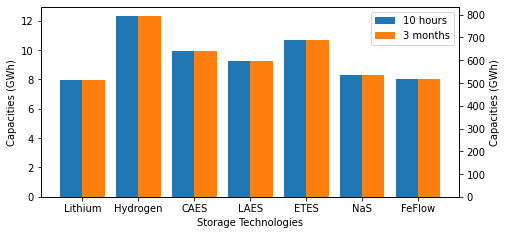

In [10]:

x=["Lithium", "Hydrogen", "CAES", "LAES", "ETES", "NaS", "FeFlow"]
y1 = storageCapacitiesdf["Capacities (10h)"].values/1000
y2 = storageCapacitiesdf["Capacities (3M)"].values/1000

plt.rcParams["figure.figsize"] = [7.50, 3.50]

X_axis = np.arange(len(x))
  
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(X_axis - 0.2, y1, 0.4, label = '10 hours', color="#1f77b4")
ax2.bar(X_axis + 0.2, y2, 0.4, label = '3 months')

b1 = ax1.bar(X_axis - 0.2, y1, 0.4, label = '10 hours', color="#1f77b4")
b2 = ax2.bar(X_axis + 0.2, y2, 0.4, label = '3 months')
  
plt.xticks(X_axis, x)
ax1.set_xlabel("Storage Technologies")
ax1.set_ylabel("Capacities (GWh)")
ax2.set_ylabel("Capacities (GWh)")

ax1.plot()
ax2.plot()

plt.legend([b1, b2], ["10 hours", "3 months"])

In [12]:
print(storageObjectivesdf["Objective (10h)"]/1e9)
print(storageObjectivesdf["Objective (3M)"]/1e9)

Lithium     2.829682
Hydrogen    2.862280
CAES        3.730459
LAES        3.016688
ETES        2.227460
NaS         6.292171
Fe-Flow     5.766977
Name: Objective (10h), dtype: float64
Lithium      99.832205
Hydrogen     11.111246
CAES          5.821842
LAES         58.334305
ETES         62.387845
NaS         333.255345
Fe-Flow      69.328125
Name: Objective (3M), dtype: float64


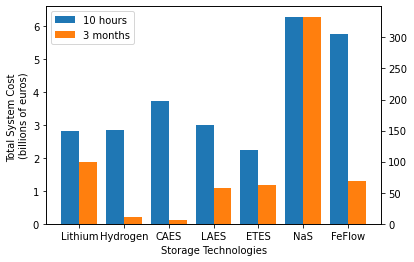

In [6]:

x=["Lithium", "Hydrogen", "CAES", "LAES", "ETES", "NaS", "FeFlow"]
y1 = storageObjectivesdf["Objective (10h)"].values/1e9
y2 = storageObjectivesdf["Objective (3M)"].values/1e9

X_axis = np.arange(len(x))
  
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(X_axis - 0.2, y1, 0.4, label = '10 hours', color="#1f77b4")
ax2.bar(X_axis + 0.2, y2, 0.4, label = '3 months')

b1 = ax1.bar(X_axis - 0.2, y1, 0.4, label = '10 hours', color="#1f77b4")
b2 = ax2.bar(X_axis + 0.2, y2, 0.4, label = '3 months')
  
plt.xticks(X_axis, x)
ax1.set_xlabel("Storage Technologies")
ax1.set_ylabel("Total System Cost \n(billions of euros)")
# ax2.set_ylabel("Total System Cost ()")

ax1.plot()
ax2.plot()

plt.legend([b1, b2], ["10 hours", "3 months"])
plt.show()

In [7]:
# fig, (ax1, ax2) = plt.subplots(1,2)

# x=["Lithium", "Hydrogen", "CAES", "LAES", "ETES", "NaS", "FeFlow"]
# y1 = storageCapacitiesdf["Capacities (10h)"].values/1000
# y2 = storageCapacitiesdf["Capacities (3M)"].values/1000

# # plt.rcParams["figure.figsize"] = [7.50, 3.50]

# X_axis = np.arange(len(x))
# ax11 = ax1.twinx()

# ax1.bar(X_axis - 0.2, y1, 0.4, label = '10 hours', color="#1f77b4")
# ax11.bar(X_axis + 0.2, y2, 0.4, label = '3 months')

# b1 = ax1.bar(X_axis - 0.2, y1, 0.4, label = '10 hours', color="#1f77b4")
# b2 = ax2.bar(X_axis + 0.2, y2, 0.4, label = '3 months')
  
# plt.xticks(X_axis, x)
# ax1.set_xlabel("Storage Technologies")
# ax1.set_ylabel("Capacities (GW)")
# ax11.set_ylabel("Capacities (GW)")

# ax1.plot()
# ax11.plot()

# plt.legend([b1, b2], ["10 hours", "3 months"])

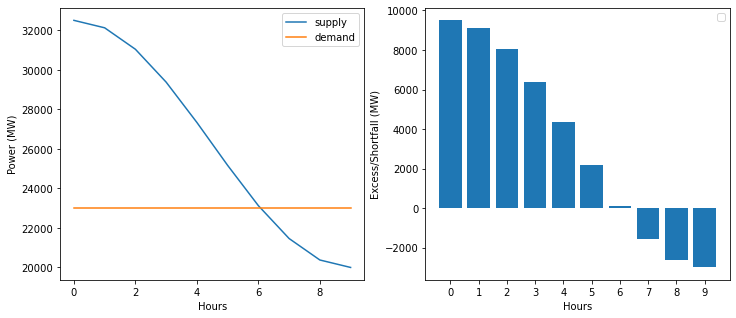

In [8]:
import numpy as np
plt.rcParams["figure.figsize"] = [12,5]

fig, (ax1,ax2) = plt.subplots(1,2)

x=np.arange(0,10,1)
y1=6250*np.cos(x*(np.pi/9))+26250
y2=np.array([23000]*10)
y3=6250*np.cos(x*(np.pi/9))+26250-23000

# ax2=ax1.twinx()

ax1.plot(y1,label='supply')
ax1.plot(y2,label='demand')
ax1.set_xlabel('Hours')
ax1.set_ylabel('Power (MW)')
ax1.legend()

ax2.bar(np.arange(10),y3)
ax2.set_xlabel('Hours')
ax2.set_ylabel('Excess/Shortfall (MW)')

plt.xticks(np.arange(10),x)
plt.legend()
plt.show()
